In [22]:
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.filters import gaussian
from sklearn.cluster import KMeans
import cv2 as opencv
import time





In [12]:
plt.close('all')
clear = lambda: os.system('clear')


In [6]:
np.random.seed(110)
segmentCounts = [2,3,4,5]
inputpath="/home/taneesh/5thSem/Computer Vision/EM_color_image_segmentation/Lab1_question_&_data/Input"


In [14]:
def pixels_num(imagepath):
    w, h =Image.open(imagepath).size
    return w*h


for imagename in os.listdir(inputpath):
    for segments in segmentCounts:
        #print(imagename)
        image=os.path.join(inputpath, imagename)
        img1=mpimg.imread(image)
        #plt.figure()
        #plt.imshow(img)
       # print('Using Matplotlib Image Library: Image is of datatype ',img.dtype,'and size ',img.shape)

        #using PIL
        img2= Image.open(image)
        print('Using Pillow (Python Image Library): Image is of datatype ',img1.dtype,'and size ',img1.shape)
        num_seg=segments
        num_pixels=pixels_num(image)
        iter_count=20
        num_color=3
        outputpath =os.path.join(''.join(['Output/',str(num_seg), '_segments/', imagename[:-4], '/']))
        if not (os.path.exists(outputpath)):
            os.makedirs(outputpath)

        img2.save(os.path.join(outputpath, "0.png"))
        pixels=np.asarray(img2)
       # print(imgarray)
        #print("hello")
        pixels=pixels.reshape(num_pixels, num_color,1)
        # here we are initializing the vectors for calculations
        # pi is the proportions vector which tells the relative proportions of the presence of each segment of the image.

        pi = 1/num_seg*(np.ones((num_seg, 1),dtype='float'))
        increment = np.random.normal(0,.0001,1)
        for seg_ctr in range(len(pi)):
            if(seg_ctr%2==1):
                pi[seg_ctr] = pi[seg_ctr] + increment
            else:
                pi[seg_ctr] = pi[seg_ctr] - increment
        
        #%% "here we initialize the mu matrix which is num_seg * num_color matrix, that is means of the particular segment that is what is the color of the each segment. We first initialize it by ones. 
        mu = (1/num_seg)*( np.ones((num_seg, num_color), dtype='float'))

        for seg_ctr in range(num_seg):
            if(seg_ctr%2==1):
                increment = np.random.normal(0,.0001,1)
            for col_ctr in range(num_color):
                #print(increment)
                if(seg_ctr%2==1):
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
                else:
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment

        #now we have setup the things and now need to iterate which is the soul of EM algorithm.
        mu_last_iter=mu;
        pi_last_iter=pi;

        for iter in range(iter_count):
            print(''.join(['Image: ',imagename,' num_seg: ',str(num_seg), 'iteration:',  str(iter+1), ' E-step']))
            Ws = np.ones((num_pixels,num_seg),dtype='float')
            for pix_ctr in range(num_pixels):
                logAjVec=np.zeros((num_seg, 1), dtype='float')
                for seg_ctr in range(num_seg):
                    x_minus_mu_T = np.transpose(pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T)

                    x_minus_mu= ((pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T))

                    
                    logAjVec[seg_ctr] = np.log(pi[seg_ctr]) - .5*(np.dot(x_minus_mu_T,x_minus_mu))

                logAmax=max(logAjVec.tolist())
                thirdterm=0
                for seg_ctr in range(num_seg):
                    thirdterm=thirdterm+np.exp(logAjVec[seg_ctr] - logAmax)
                for seg_ctr in range(num_seg):
                    logY = logAjVec[seg_ctr] - logAmax - np.log(thirdterm)
                    Ws[pix_ctr][seg_ctr] = np.exp(logY)

            # this all has been shown mathematically in the report that how are we going about it. 
        ##############################################################################################
        ############### M-step#############

            print(''.join(['Image: ',imagename,' num_seg: ',str(num_seg), 'iteration:',  str(iter+1), ' M-step:mixture coefficients'])) 
            mu = np.zeros((num_seg, num_color), dtype='float')
            #mean color for each segment
            pi = np.zeros((num_seg, 1), dtype='float') #proportion in which the segments are there.

            for seg_ctr in range(num_seg):
                prob_sum=0
                for pix_ctr in range(num_pixels):
                    mu[seg_ctr] = mu[seg_ctr,:][np.newaxis] + pixels[pix_ctr].T * (Ws[pix_ctr, seg_ctr]) # proved mathematically. that mu new is weighted sum of the pixels. 
                    
                    prob_sum+= Ws[pix_ctr, seg_ctr]

                mu[seg_ctr]= mu[seg_ctr]/prob_sum
                pi[seg_ctr] = prob_sum/num_pixels

            #print(np.transpose(pi))
           # print("   ")

            muDiffSq = np.sum(np.multiply((mu - mu_last_iter),(mu -mu_last_iter)))
            piDiffSq = np.sum(np.multiply((pi - pi_last_iter),(pi - pi_last_iter)))
            
            if (muDiffSq < .0000001 and piDiffSq < .0000001): 
                print('Convergence Criteria Met at Iteration: ',iter, ' Exiting code')
                break

            mu_last_iter= mu
            pi_last_iter=pi
            segpixels=np.array(pixels)
            cluster=0
            for pix_ctr in range(num_pixels):
                cluster=np.where(Ws[pix_ctr,:]== max(Ws[pix_ctr,:]))
                vec= np.squeeze(np.transpose(mu[cluster,:]))
                segpixels[pix_ctr,:]= vec.reshape(vec.shape[0], 1)

            """ Save segmented image at each iteration. For displaying consistent image clusters, it would be useful to blur/smoothen the segpixels image using a Gaussian filter.  
                Prior to smoothing, convert segpixels to a Grayscale image, and convert the grayscale image into clusters based on pixel intensities"""

            segpixels = np.reshape(segpixels,(img1.shape[0], img1.shape[1], num_color))
            # it's rgb array of image
            segmented_image= Image.fromarray(segpixels)
            
            #img2.save(os.path.join(outputpath, "0.png"))
            
            #segmented_image.save(os.path.join(outputpath, pic_name))

            #seg pixels is segmented image's numpy array.
            #rgb_weights for image conversion are used to be [0.2989, 0.5870, 0.1140]. 
            # here I manually turned image into grayscale

            #rgb_weights= [0.2989, 0.5870, 0.1140]
            #grayscale_seg= np.dot(segpixels[..., :3], rgb_weights) 
            #info = np.iinfo(segpixels.dtype)
            #grayscale_seg= grayscale_seg.astype(np.float)/ info.max
            #grayscale_seg = grayscale_seg * 255
            #grayscale_seg=grayscale_seg.astype(np.uint8)

            colors = [[1,0,0],[0,1,0],[0,0,1],[0.5,0.5,0.5],[0.5,0,0.2]]
            segpixels = rgb2gray(segpixels.astype('uint8')) # convert to grayscale

            # now I have grayscale uint array on which kmeans can be used;

            ############## using Kmeans to cluseter grayscale image############33
            kmeans = KMeans(num_seg).fit(np.reshape(segpixels, (segpixels.shape[0] * segpixels.shape[1], 1))) 

    
            labels=kmeans.labels_
            labels=np.reshape(labels, (img1.shape[0], img1.shape[1]))
            labels = gaussian(np.clip(label2rgb(labels, colors=colors ), 0,  1), sigma = 2,                    multichannel=False)
            pic_name= str(iter+1)
            pic_name+=".png"
            
            mpimg.imsave(os.path.join(outputpath, pic_name), labels)
            

             









ype  float32 and size  (480, 319, 3)
Image: jump.png num_seg: 5iteration:1 E-step
Image: jump.png num_seg: 5iteration:1 M-step:mixture coefficients
Image: jump.png num_seg: 5iteration:2 E-step
Image: jump.png num_seg: 5iteration:2 M-step:mixture coefficients
Image: jump.png num_seg: 5iteration:3 E-step
Image: jump.png num_seg: 5iteration:3 M-step:mixture coefficients
Image: jump.png num_seg: 5iteration:4 E-step
Image: jump.png num_seg: 5iteration:4 M-step:mixture coefficients
Image: jump.png num_seg: 5iteration:5 E-step
Image: jump.png num_seg: 5iteration:5 M-step:mixture coefficients
Image: jump.png num_seg: 5iteration:6 E-step
Image: jump.png num_seg: 5iteration:6 M-step:mixture coefficients
Image: jump.png num_seg: 5iteration:7 E-step
Image: jump.png num_seg: 5iteration:7 M-step:mixture coefficients
Image: jump.png num_seg: 5iteration:8 E-step
Image: jump.png num_seg: 5iteration:8 M-step:mixture coefficients
Image: jump.png num_seg: 5iteration:9 E-step
Image: jump.png num_seg: 5iter

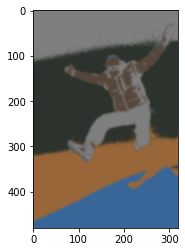

In [31]:
for dirs in os.listdir('Output'):
    for files in os.listdir(join('Output/', dirs)):
        for images in os.listdir(join('Output/',  dirs, files)):
            input = "Output/" + dirs +"/" +files +"/" + images
            img=mpimg.imread(input)
            plt.figure()
            plt.imshow(img)


